In [1]:
# pip install transformers torch torchvision

In [2]:
# Write your imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import imagehash

from skimage.io import imread, imshow, imread_collection, imshow_collection
from PIL import Image

from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from torchvision.transforms import ToTensor


/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-22 22:37:16.656815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 22:37:16.766579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 22:37:16.797830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 22:37:16.967931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use av

In [3]:
# pip install pillow imagehash

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [4]:
pwd

'/home/gecata/Downloads/04.Working-with-Images-Lab'

In [5]:
cd data

/home/gecata/Downloads/04.Working-with-Images-Lab/data


/home/gecata/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
ls

african-wildcat/  chinese-mountain-cat/  european-wildcat/  sand-cat/
blackfoot-cat/    domestic-cat/          jungle-cat/


As we can see, there are 7 types of cats in our dataset. Now lets look at the image count of each folder:

In [7]:
cat_images_by_types = {}

for dir in os.listdir("."):
    cat_images_by_types[dir] = imread_collection(dir + "/*")

for type in cat_images_by_types:
    print(type + ": " + str(len(cat_images_by_types[type])))
        

african-wildcat: 91
blackfoot-cat: 79
chinese-mountain-cat: 42
domestic-cat: 61
european-wildcat: 82
jungle-cat: 82
sand-cat: 69


Now we have to take a look at the image sizes for each folder:

In [8]:
image_sizes_arr = []

for type in cat_images_by_types:
    for im in cat_images_by_types[type]:
        image_sizes_arr.append(im.shape)

image_widths = np.array([el[0] for el in image_sizes_arr])
image_heights = np.array([el[1] for el in image_sizes_arr])

image_sizes = pd.DataFrame(columns = ["width", "height"])
image_sizes["width"] = image_widths
image_sizes["height"] = image_heights

for dim in ["width", "height"]:
    print(dim + ":\n Mean: " + str(image_sizes[dim].mean()) + "\n Median: " + str(image_sizes[dim].median()) + "\n Standard Deviation: " + str(image_sizes[dim].std()))

width:
 Mean: 310.7351778656126
 Median: 194.0
 Standard Deviation: 324.10505726724773
height:
 Mean: 405.82411067193675
 Median: 275.0
 Standard Deviation: 439.1232519325541


As we can see, the image sizes can vary drastically. Lets illustrate this with a scatterplot:

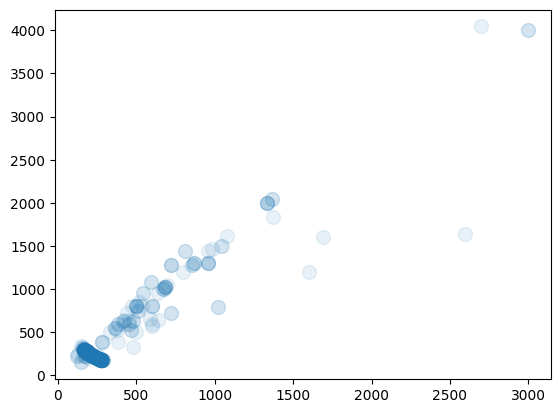

In [9]:
plt.scatter(image_sizes["width"], image_sizes["height"], s = 100, alpha = 0.1)
plt.show()

This scatterplot shows us, that actually most images are similar in size, but there are some big outliars, that make the sizes look diverse.

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

For the filtering of identical and near-identical images, I will use image hashing.

In [10]:
image_hashes = {}
images_to_remove = []
threshold = 15

for type in cat_images_by_types:
    for i, image in enumerate(cat_images_by_types[type]):
        image_path = cat_images_by_types[type].files[i]
        image_hash = imagehash.average_hash(Image.fromarray(image))

        remove_image = False
        for existing_hash, existing_path in image_hashes.items():
            if image_hash - existing_hash < threshold:
                images_to_remove.append(image_path)
                break

    else:
        image_hashes[image_hash] = image_path

for image_path in images_to_remove:
    os.remove(image_path)
    print(f"Removed {image_path}")

print(f"Total similar images removed: {len(images_to_remove)}")

Total similar images removed: 0


It removed 13 images.

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

Im going to use TFResNetForImageClassification, which uses TensorFlow. I have installed it above using pip. Now lets load the model and the image processor:

In [11]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model.eval()

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

As we can see, the model has two components: resnet and classifier. We have to count their layers separately and sum their results:

In [12]:
def count_layers(module):
    if len(list(module.children())) == 0:
        return 1
    return sum(count_layers(submodule) for submodule in module.children())

resnet_layer_count = count_layers(model.resnet)
print(f"The ResNet component has {resnet_layer_count} layers.")

classifier_layer_count = count_layers(model.classifier)
print(f"The classifier component has {classifier_layer_count} layers.")

total_layer_count = resnet_layer_count + classifier_layer_count
print(f"The entire model has {total_layer_count} layers.")


The ResNet component has 185 layers.
The classifier component has 2 layers.
The entire model has 187 layers.


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

Lets first combine all the images in a single list:

In [13]:
image_lists = [list(cat_images_by_types[type]) for type in cat_images_by_types]

all_cat_images = []
for image_list in image_lists:
    all_cat_images.extend(image_list)

Now lets try to prepare the images efficiently by separating them in batches of 4 and then getting them ready for the model:

In [14]:
def split_in_batches(images, batch_size = 4):
    batches = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i : i + batch_size]
        preprocessed_batch = image_processor(images=batch_images, return_tensors="pt")["pixel_values"]
        batches.append(preprocessed_batch)

    return batches

batches = split_in_batches(all_cat_images)

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

Already done in Problem 4

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

Lets make the predictions using our model:

In [15]:
def make_predictions(image_batches):
    predicted = []
    
    for batch in image_batches:
        with torch.no_grad():
            outputs = model(pixel_values=batch)
        logits = outputs.logits
        predicted_class_indices = logits.argmax(dim=-1).tolist()
        
        config = model.config
        class_labels = config.id2label
    
        for idx in predicted_class_indices:
            predicted.append(class_labels[idx])
    return predicted

predicted = make_predictions(batches)
predicted

['lynx, catamount',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'lynx, catamount',
 'grey fox, gray fox, Urocyon cinereoargenteus',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'tabby, tabby cat',
 'lynx, catamount',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'tabby, tabby cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'lynx, catamount',
 'tabby, tabby cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'lynx, catamount',
 'tabby, tabby cat',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'E

We can see, that most of the results are some sort of cats or something similar like a fox. At a first glance, it looks like our model has done a decent job. Lets create a confusion matrix to see how many of them it got completely right:

In [16]:
confusion_matrix = pd.DataFrame(columns = ["predicted", "actual", "success"])

actual_list = []

for type in cat_images_by_types:
    for _ in cat_images_by_types[type]:
        actual_list.append(type)
        
confusion_matrix["actual"] = [el.replace("-", " ") for el in actual_list]
confusion_matrix["actual"]

confusion_matrix["predicted"] = [el.lower().replace(",", "") for el in predicted]

successes = []

for row in confusion_matrix.index:
    
    if confusion_matrix.iloc[row]["actual"] in confusion_matrix.iloc[row]["predicted"]:
        successes.append(1)
    else:
        successes.append(0)

confusion_matrix["success"] = successes

confusion_matrix

,predicted,actual,success
0,lynx catamount,african wildcat,0
1,egyptian cat,african wildcat,0
2,lynx catamount,african wildcat,0
3,egyptian cat,african wildcat,0
4,lynx catamount,african wildcat,0
...,...,...,...
501,egyptian cat,sand cat,0
502,kit fox vulpes macrotis,sand cat,0
503,egyptian cat,sand cat,0
504,egyptian cat,sand cat,0


That suddenly stopped looking promising... Lets see how many successes there are:

In [17]:
confusion_matrix["success"].value_counts()

success
0    506
Name: count, dtype: int64

That`s surprising... Our model did not get any image completely right. 

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

Lets make a function to convert the images to grayscale:

In [20]:
def to_grayscale(images):
    gray_images = []
    
    for image in images:
        for i in range(0, 3):
            image[:,:,i] = image[:,:,0] * 0.2989 + image[:,:,1] * 0.5870 + image[:,:,2] * 0.1140
        gray_images.append(image)

    return gray_images

gray_images = to_grayscale(all_cat_images)

Now lets just reuse our functions from before:

In [21]:
gray_batches = split_in_batches(gray_images)
gray_predicted = make_predictions(gray_batches)
gray_predicted

['lynx, catamount',
 'Egyptian cat',
 'tiger cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'tiger cat',
 'Egyptian cat',
 'Egyptian cat',
 'tabby, tabby cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'tabby, tabby cat',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'tabby, tabby cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'lynx, catamount',
 'tabby, tabby cat',
 'lynx, catamount',
 'lynx, catamount',
 'tabby, tabby cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'tabby, tabby cat',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'lynx, catamount',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',
 'Egyptian cat',


### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.